# Entrega Trabajo Práctico Final: Lucía Chicharro, María Montero y Patricia Ramos.

Para este trabajo se copiará el estilo de diferentes imágenes en otras imágenes reales. Para ello se empleará el Neural Style Transfer (Transferencia de Estilo Neuronal) que consiste en aplicar el estilo de una imagen de referencia a una imagen de destino conservando el contenido de la imagen de destino.

Funciones auxiliares necesarias para **cargar**, **preprocesar** y **posprocesar** las imágenes que **entran** y **salen** de la **convnet VGG19**

In [ ]:
from tensorflow import keras
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
# Función útil para abrir, cambiar el tamaño y
# formatear imágenes en sus matrices correspondientes
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Función útil para convertir una matriz NumPy en una imagen válida
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Centrado a cero mediante la eliminación del valor
    # de píxel medio de ImageNet. Esto invierte una
    # transformación realizada por vgg19.preprocess_input
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convierte imágenes de 'BGR' a 'RGB'. Esto también es
    # parte de la reversión de lo hecho por vgg19.preprocess_input
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Usamos un modelo VGG19 preentrenado para extraer las características.

In [ ]:
# Creamos un modelo VGG19 cargado con pesos preentrenados con ImageNet
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Modelo que devuelve los valores de activación
# para cada capa de destino (como un diccionario)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Definimos la **content loss** que garantizará que la **capa superior de la convnet VGG19 tenga una vista similar de la imagen de estilo** y la **combination image**

In [ ]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

Definimos la **'style loss'**.

Utiliza una función auxiliar para **calcular la matriz de Gram** de una **matriz de entrada**: un **mapa de las correlaciones encontradas en la matriz de características original**.

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

Definimos la **Pérdida de Variación Total** que logra que el resultado final no sea excesivamente pixelado.

In [ ]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

Definimos la pérdida final que es un promedio ponderado de las tres pérdidas.

Para calcular la **'content loss'**, usamos solo una capa superior, la capa ``block5_conv2``, mientras que para la **'style loss'**, usamos una lista de capas que abarca capas de bajo y alto nivel. Agregamos la pérdida de variación total al final.

Al poner una variación total pequeña, estamos permitiendo que la imagen final se deforme pudiendo incorporar cierto ruido que para los casos que se van a plantear es beneficioso. Además, disminuiremos el valor del "content_weight" para que se pueda aplicar correctamente el estilo que en este caso precisa de deformaciones en las figuras de la imagen original. Se ha decidido no aumentar el estilo ya que se ha comprobado que son estilos demasiado agresivos y se pierde mucha calidad en la imagen.

In [ ]:
# Lista de capas a usar para la 'style loss'
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# La capa a usar para la 'content loss'
content_layer_name = "block5_conv2"
# Peso de la contribución de la pérdida de variación total
total_variation_weight = 1e-6
# Peso de la contribución de la 'style loss'
style_weight = 1e-6
# Peso de la contribución de la 'content loss'
content_weight = 2.5e-20

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # Inicializamos la pérdida a 0
    loss = tf.zeros(shape=())
    # Agrega la 'content loss'
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Añade la 'style loss'
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Añade la pérdida de variación total.
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

Definimos el **descenso de gradiente** de **mini lotes** con el **optimizador ``SGD``**

In [ ]:
# Hacemos que el paso de entrenamiento sea
# rápido al compilarlo como una función tf.
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    # Comenzaremos con una tasa de aprendizaje de 100
    # y la disminuiremos en un 4 % cada 100 pasos.
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)


## De imagen real a dibujo.


En este primer caso, se pretende convertir una imagen de un castillo real en un dibujo realizado con lápiz. Esto puede ser útil a la hora de emplearlo para ilustrar libros o cuentos infantiles.

In [ ]:
# Path a la imagen que queremos transformar
base_image_path = os.path.abspath("castillo.jpg")

# Path a la imagen de estilo
style_reference_image_path =os.path.abspath("dibujo.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
# Dimensiones de la imagen generada
img_height = 400
img_width = round(original_width * img_height / original_height)

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# Usamos una variable para almacenar la imagen combinada,
# ya que la actualizaremos durante el entrenamiento.
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # Actualizamos la imagen combinada en una dirección que
    # reduzca la pérdida de transferencia de estilo.
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"Cast_combination_image_at_iteration_{i}.png"
        # Guardamos la imagen combinada a intervalos regulares.
        keras.utils.save_img(fname, img)

Iteration 100: loss=9909.91
Iteration 200: loss=8244.71
Iteration 300: loss=7522.49
Iteration 400: loss=7094.96
Iteration 500: loss=6808.56
Iteration 600: loss=6594.75
Iteration 700: loss=6427.73
Iteration 800: loss=6293.71
Iteration 900: loss=6180.99
Iteration 1000: loss=6084.60
Iteration 1100: loss=5999.80
Iteration 1200: loss=5924.66
Iteration 1300: loss=5858.36
Iteration 1400: loss=5798.36
Iteration 1500: loss=5744.70
Iteration 1600: loss=5695.64
Iteration 1700: loss=5650.57
Iteration 1800: loss=5608.99
Iteration 1900: loss=5570.89
Iteration 2000: loss=5535.65
Iteration 2100: loss=5503.69
Iteration 2200: loss=5474.30
Iteration 2300: loss=5447.11
Iteration 2400: loss=5421.63
Iteration 2500: loss=5397.81
Iteration 2600: loss=5375.47
Iteration 2700: loss=5354.42
Iteration 2800: loss=5334.60
Iteration 2900: loss=5315.58
Iteration 3000: loss=5297.59
Iteration 3100: loss=5280.65
Iteration 3200: loss=5264.35
Iteration 3300: loss=5248.89
Iteration 3400: loss=5234.35
Iteration 3500: loss=52

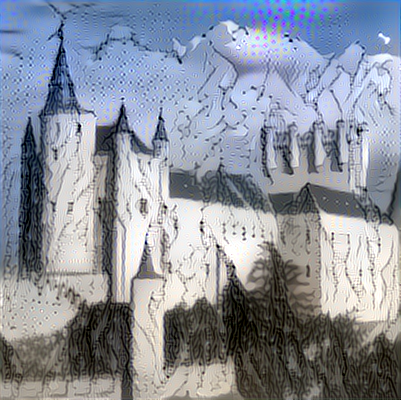

Imagen original:




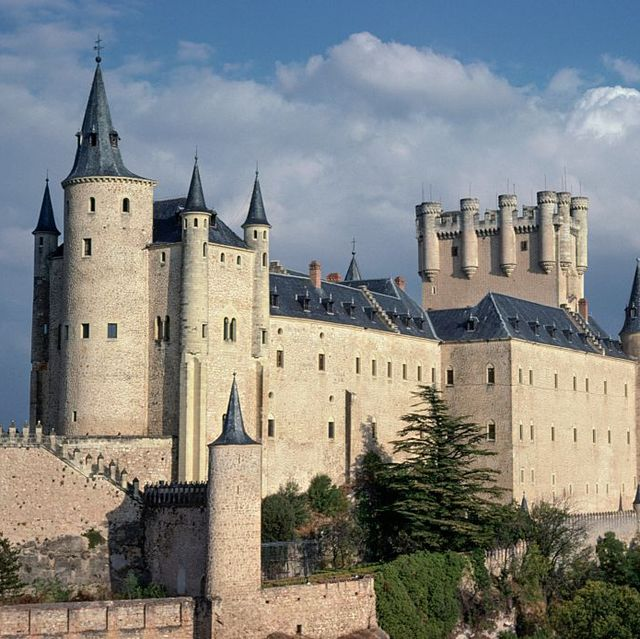

Adicionalmente, se expondrán los resultados obtenidos utilizando el modelo Hub de Tensorflow.

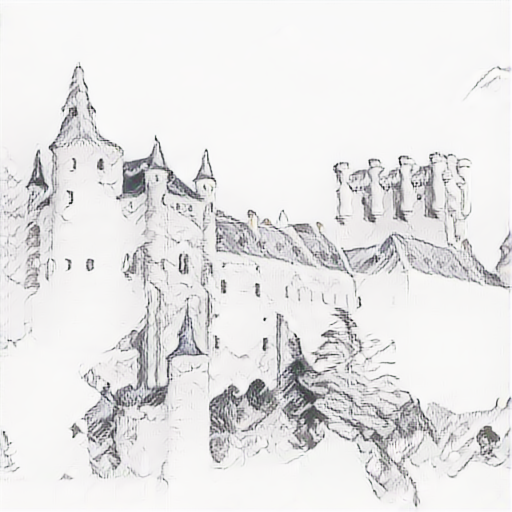

In [ ]:
content_image = load_img(base_image_path)
style_image = load_img(style_reference_image_path)

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Claramente en este caso funciona mejor el segundo programa.

## De cuadro a vidriera.

La segunda aplicación consiste en convertir un cuadro real en una vidriera.

En primer lugar se empleará el cuadro de Adán y Eva.

ANTES DE EJECUTAR EL RESTO DE EJEMPLOS ES NECESARIO REINICIAR EL ENTORNO

In [ ]:
# Path a la imagen que queremos transformar
base_image_path1 = os.path.abspath("AYE.jpeg")

# Path a la imagen de estilo
style_reference_image_path1 =os.path.abspath("vidriera2.jpeg")

original_width, original_height = keras.utils.load_img(base_image_path1).size
# Dimensiones de la imagen generada
img_height = 400
img_width = round(original_width * img_height / original_height)

In [ ]:
base_image = preprocess_image(base_image_path1)
style_reference_image = preprocess_image(style_reference_image_path1)
# Usamos una variable para almacenar la imagen combinada,
# ya que la actualizaremos durante el entrenamiento.
combination_image = tf.Variable(preprocess_image(base_image_path1))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # Actualizamos la imagen combinada en una dirección que
    # reduzca la pérdida de transferencia de estilo.
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"AYE_combination_image_at_iteration_{i}.png"
        # Guardamos la imagen combinada a intervalos regulares.
        keras.utils.save_img(fname, img)

Iteration 100: loss=7532.89
Iteration 200: loss=4987.97
Iteration 300: loss=4366.89
Iteration 400: loss=3840.17
Iteration 500: loss=3690.98
Iteration 600: loss=3440.48
Iteration 700: loss=4069.89
Iteration 800: loss=2996.77
Iteration 900: loss=2925.55
Iteration 1000: loss=3204.60
Iteration 1100: loss=2751.62
Iteration 1200: loss=2663.70
Iteration 1300: loss=2579.13
Iteration 1400: loss=2517.93
Iteration 1500: loss=2466.27
Iteration 1600: loss=2455.31
Iteration 1700: loss=2415.36
Iteration 1800: loss=2363.36
Iteration 1900: loss=2328.66
Iteration 2000: loss=2298.21
Iteration 2100: loss=2272.55
Iteration 2200: loss=2248.99
Iteration 2300: loss=2227.37
Iteration 2400: loss=2207.44
Iteration 2500: loss=2189.03
Iteration 2600: loss=2172.04
Iteration 2700: loss=2156.36
Iteration 2800: loss=2141.94
Iteration 2900: loss=2128.53
Iteration 3000: loss=2116.06
Iteration 3100: loss=2104.40
Iteration 3200: loss=2093.50
Iteration 3300: loss=2083.27
Iteration 3400: loss=2073.59
Iteration 3500: loss=20

image.png

Imagen original:

AYE.jpeg

Veamos los resultados con el modelo Hub.

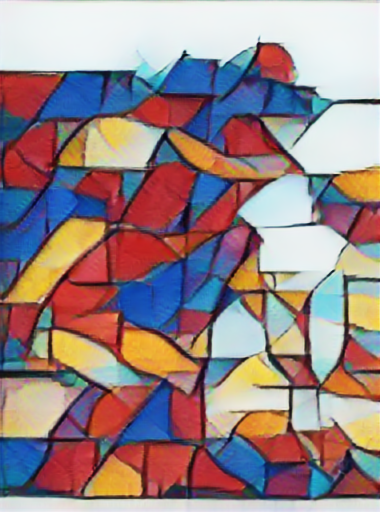

In [ ]:
content_image = load_img(base_image_path1)
style_image = load_img(style_reference_image_path1)

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

En segundo lugar, se empleará el cuadro de La Gioconda.

In [ ]:
# Path a la imagen que queremos transformar
base_image_path = os.path.abspath("mona.jpg")

# Path a la imagen de estilo
style_reference_image_path =os.path.abspath("vidriera2.jpeg")

original_width, original_height = keras.utils.load_img(base_image_path).size
# Dimensiones de la imagen generada
img_height = 400
img_width = round(original_width * img_height / original_height)

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# Usamos una variable para almacenar la imagen combinada,
# ya que la actualizaremos durante el entrenamiento.
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # Actualizamos la imagen combinada en una dirección que
    # reduzca la pérdida de transferencia de estilo.
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"mona_combination_image_at_iteration_{i}.png"
        # Guardamos la imagen combinada a intervalos regulares.
        keras.utils.save_img(fname, img)

Iteration 100: loss=15791.95
Iteration 200: loss=8529.46
Iteration 300: loss=7836.81
Iteration 400: loss=4628.41
Iteration 500: loss=3710.57
Iteration 600: loss=10708.74
Iteration 700: loss=3744.64
Iteration 800: loss=3529.11
Iteration 900: loss=3201.53
Iteration 1000: loss=2881.75
Iteration 1100: loss=2865.37
Iteration 1200: loss=2725.13
Iteration 1300: loss=2864.24
Iteration 1400: loss=2591.55
Iteration 1500: loss=2652.43
Iteration 1600: loss=2481.47
Iteration 1700: loss=2469.47
Iteration 1800: loss=2416.33
Iteration 1900: loss=2382.71
Iteration 2000: loss=2337.78
Iteration 2100: loss=2305.70
Iteration 2200: loss=2281.60
Iteration 2300: loss=2260.09
Iteration 2400: loss=2239.69
Iteration 2500: loss=2221.02
Iteration 2600: loss=2203.69
Iteration 2700: loss=2187.81
Iteration 2800: loss=2172.97
Iteration 2900: loss=2159.33
Iteration 3000: loss=2146.68
Iteration 3100: loss=2134.83
Iteration 3200: loss=2123.90
Iteration 3300: loss=2113.76
Iteration 3400: loss=2104.39
Iteration 3500: loss=

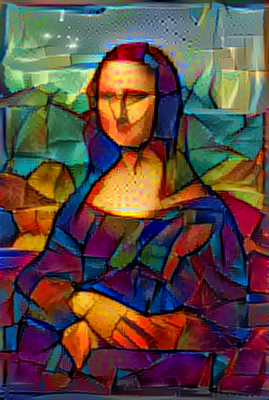

Imagen original:

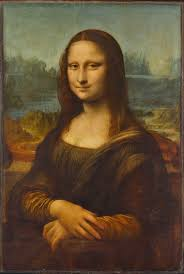

Veamos los resultados con el modelo Hub.

In [ ]:
content_image = load_img(base_image_path)
style_image = load_img(style_reference_image_path)

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Como se puede observar, para los dos últimos ejemplos funciona mejor el primer programa implementado.